# ***Data Processing***

V. 1.02

In [28]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [15]:
movies = pd.DataFrame(pd.read_csv("movies.csv"))
movies = movies.drop(['Unnamed: 0'], axis=1)

movies.loc[movies["Year"] == '    ', ['Year']] = 0 
movies["Year"] = movies["Year"].fillna(-1)
movies["Year"] = movies["Year"].astype(float)

movies = movies[~movies['Budget'].astype(str).str.contains('Budget:')]
movies = movies[~movies['Budget'].astype(str).str.contains('Trivia')]
movies["Budget"] = movies["Budget"].str.replace(',','')
movies["Budget"] = movies["Budget"].fillna(-1)
movies["Budget"] = movies["Budget"].astype(float)

movies["Gross US"] = movies["Gross US"].str.replace(',','')
movies["Gross US"] = movies["Gross US"].fillna(-1)
movies["Gross US"] = movies["Gross US"].astype(float)

movies["Gross WW"] = movies["Gross WW"].str.replace(',','')
movies["Gross WW"] = movies["Gross WW"].fillna(-1)
movies["Gross WW"] = movies["Gross WW"].astype(float)

movies["Language"] = movies["Language"].fillna(-1)

movies["Rating"] = movies["Rating"].fillna('Unrated')

movies["Duration"] = movies["Duration"].fillna(-1)
movies=movies.rename(columns = {'Duration':'Duration_Minutes'})

movies=movies.rename(columns = {'Average Rating':'Average_Rating'})
print(movies.dtypes)

Name                   object
Year                  float64
Genres                 object
Rating                 object
Duration_Minutes      float64
Actors                 object
Director               object
Average_Rating        float64
Budget                float64
Opening Weekend       float64
Gross US              float64
Gross WW              float64
Language               object
Production Company     object
dtype: object


Filling NA with median value

In [16]:
# def fill_nan(col):
#     movies[col] = movies[col].fillna(movies[col].median())

# cols = list(movies.columns)
# fill_nan(cols)

In [17]:
movies.columns

Index(['Name', 'Year', 'Genres', 'Rating', 'Duration_Minutes', 'Actors',
       'Director', 'Average_Rating', 'Budget', 'Opening Weekend', 'Gross US',
       'Gross WW', 'Language', 'Production Company'],
      dtype='object')

In [18]:
movies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
0,Pulp Fiction,1994.0,"['Crime', 'Drama']",R,154.0,"['John Travolta', 'Uma Thurman', 'Samuel L. Ja...",['Quentin Tarantino'],8.9,8000000.0,9311882.0,107928762.0,213928762.0,"['English', 'Spanish', 'French']","['Miramax', 'ABandApart', 'JerseyFilms']"
1,The Amazing Spider-Man 2,2014.0,"['Action', 'Adventure', 'Sci-Fi']",PG-13,142.0,"['Andrew Garfield', 'Emma Stone', 'Jamie Foxx'...",['Marc Webb'],6.6,200000000.0,91608337.0,202853933.0,708982323.0,['English'],"['MarvelEnterprises', 'AviAradProductions', 'C..."
2,The Shawshank Redemption,1994.0,['Drama'],R,142.0,"['Tim Robbins', 'Morgan Freeman', 'Bob Gunton'...",['Frank Darabont'],9.3,25000000.0,727326.0,28341469.0,58500000.0,['English'],['CastleRockEntertainment']
3,Star Wars: Episode IV - A New Hope,1977.0,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",PG,121.0,"['Mark Hamill', 'Harrison Ford', 'Carrie Fishe...",['George Lucas'],8.6,11000000.0,1554475.0,322740140.0,775398007.0,['English'],"['Lucasfilm', 'TwentiethCenturyFox']"
4,Back to the Future,1985.0,"['Adventure', 'Comedy', 'Sci-Fi']",PG,116.0,"['Michael J. Fox', 'Christopher Lloyd', 'Lea T...",['Robert Zemeckis'],8.5,19000000.0,11332134.0,210609762.0,381109762.0,['English'],"['UniversalPictures', 'AmblinEntertainment', '..."


In [19]:
# col = list(movies.describe().columns)
# sc = StandardScaler()
# temp = sc.fit_transform(movies[col])
# movies[col] = temp
# movies.head()

In [20]:
movies.isnull().sum()

Name                     0
Year                     0
Genres                   0
Rating                   0
Duration_Minutes         0
Actors                   0
Director                 0
Average_Rating           0
Budget                   0
Opening Weekend       4231
Gross US                 0
Gross WW                 0
Language                 0
Production Company       0
dtype: int64

In [21]:
to_drop = [2020,2021,2024] #Removing future releases (no data available)
movies=movies[~movies['Year'].isin(to_drop)] 

In [22]:
movies['Rating'] = movies['Rating'].replace({'Not Rated':'Unrated'})

movies["Rating"].value_counts()

R          3974
PG-13      2020
PG         1570
Unrated    1348
G           252
TV-14        91
TV-PG        71
TV-G         53
TV-MA        44
NC-17        20
X             8
TV-Y          4
TV-Y7         4
Passed        1
GP            1
Name: Rating, dtype: int64

In [23]:
drop_tv = ['TV-14' ,'TV-G', 'TV-MA', 'TV-Y', 'TV-PG' , 'TV-Y7' , 'GP' , 'Passed' , 'X' ]  #Removing TV shows/X rated movies
movies=movies[~movies['Rating'].isin(drop_tv)] 

In [24]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9184 entries, 0 to 9836
Data columns (total 14 columns):
Name                  9184 non-null object
Year                  9184 non-null float64
Genres                9184 non-null object
Rating                9184 non-null object
Duration_Minutes      9184 non-null float64
Actors                9184 non-null object
Director              9184 non-null object
Average_Rating        9184 non-null float64
Budget                9184 non-null float64
Opening Weekend       5241 non-null float64
Gross US              9184 non-null float64
Gross WW              9184 non-null float64
Language              9184 non-null object
Production Company    9184 non-null object
dtypes: float64(7), object(7)
memory usage: 1.1+ MB


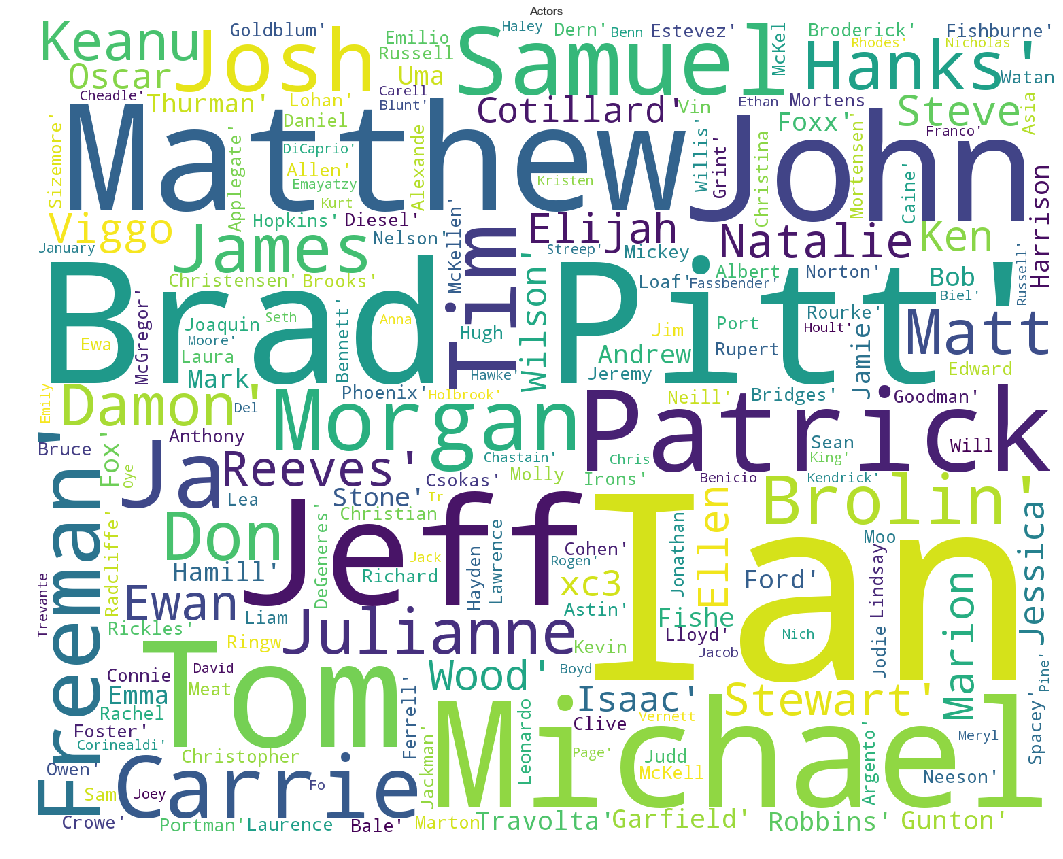

In [29]:
import random
from wordcloud import WordCloud, STOPWORDS
text = (str(movies['Actors']))
plt.subplots(figsize=(20,15))
wordcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1500,
                          height=1200
                         ).generate(text)


plt.imshow(wordcloud)
plt.title('Actors')
plt.axis('off')
plt.show()

In [30]:
# movies["Genres"].value_counts()

In [31]:
# seperate_genre='Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Fantasy','Family','History','Horror','Music','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western'
# for genre in seperate_genre:
#     df = movies['Genres'].str.contains(genre).fillna(False)
#    # print('The total number of movies with ',Genres,'=',len(movies[df]))
#     f, ax = plt.subplots(figsize=(20, 20))
#     sns.countplot(x='Year', data=movies[df], palette="Greens_d");
#     plt.title(genre)
   

In [32]:
# movies.Director.value_counts()[:10].plot.pie(autopct='%1.1f%%',figsize=(10,10))
# # plt.title('TOP 10 Directors OF MOVIES')

In [33]:
# movies.Actors.value_counts()[:10].plot.pie(autopct='%1.1f%%',figsize=(10,10))
# plt.title('TOP 10 Actors OF MOVIES')

In [34]:
movies["Year"].value_counts().to_frame()

,Year
2008.0,347
2012.0,337
2007.0,330
2009.0,320
2011.0,318
2006.0,316
2010.0,301
2005.0,297
2002.0,284
0.0,274


In [35]:
movies_09_19=movies[(2020 < movies['Year']) & (movies['Year'] > 2010)]

In [36]:
#top 10 rating movies 
Sortedrating= movies.sort_values(['Average_Rating'], ascending=False)
Sortedrating.head(10)

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
9029,Yanni Live! The Concert Event,2006.0,['Music'],Unrated,82.0,"['Charlie Adams', 'Michelle Amato', 'Kristen A...","['George Veras', 'ProReviews', 'Excellent musi...",9.5,-1.0,NaN,-1.0,-1.000000e+00,['English'],[]
2,The Shawshank Redemption,1994.0,['Drama'],R,142.0,"['Tim Robbins', 'Morgan Freeman', 'Bob Gunton'...",['Frank Darabont'],9.3,25000000.0,727326.0,28341469.0,5.850000e+07,['English'],['CastleRockEntertainment']
34,The Dark Knight,2008.0,"['Action', 'Crime', 'Drama', 'Thriller']",PG-13,152.0,"['Christian Bale', 'Heath Ledger', 'Aaron Eckh...",['Christopher Nolan'],9.0,185000000.0,158411483.0,534858444.0,1.004558e+09,"['English', 'Mandarin']","['WarnerBros.', 'LegendaryEntertainment', 'Syn..."
194,The Godfather: Part II,1974.0,"['Crime', 'Drama']",R,202.0,"['Al Pacino', 'Robert De Niro', 'Robert Duvall...",['Francis Ford Coppola'],9.0,13000000.0,NaN,57300000.0,-1.000000e+00,"['English', 'Italian', 'Spanish', 'Latin', 'Si...","['ParamountPictures', 'TheCoppolaCompany']"
0,Pulp Fiction,1994.0,"['Crime', 'Drama']",R,154.0,"['John Travolta', 'Uma Thurman', 'Samuel L. Ja...",['Quentin Tarantino'],8.9,8000000.0,9311882.0,107928762.0,2.139288e+08,"['English', 'Spanish', 'French']","['Miramax', 'ABandApart', 'JerseyFilms']"
23,The Lord of the Rings: The Return of the King,2003.0,"['Adventure', 'Drama', 'Fantasy']",PG-13,201.0,"['Elijah Wood', 'Viggo Mortensen', 'Ian McKell...",['Peter Jackson'],8.9,94000000.0,72629713.0,377845905.0,1.119930e+09,"['English', 'Quenya', 'OldEnglish', 'Sindarin']","['NewLineCinema', 'WingNutFilms', 'TheSaulZaen..."
9253,Strangers: The Story of a Mother and Daughter,1979.0,"['Drama', 'actor']",Unrated,88.0,"['Bette Davis', 'Gena Rowlands', 'Ford Rainey'...",['Milton Katselas'],8.9,-1.0,NaN,-1.0,-1.000000e+00,['English'],['Chris/RoseProductions']
9283,The Taming of the Shrew,1976.0,"['Comedy', 'Romance', 'actor']",Unrated,102.0,"['Raye Birk', 'Earl Boen', 'Ron Boussom', 'Bar...",['Kirk Browning'],8.8,-1.0,NaN,-1.0,-1.000000e+00,['English'],"['AmericanConservatoryTheatre', 'PublicBroadca..."
14,Fight Club,1999.0,['Drama'],R,139.0,"['Brad Pitt', 'Edward Norton', 'Meat Loaf', 'Z...",['David Fincher'],8.8,63000000.0,11035485.0,37030102.0,7.100000e+07,['English'],"['Fox2000Pictures', 'RegencyEnterprises', 'Lin..."
8109,Kissology: The Ultimate Kiss Collection,2006.0,"['Documentary', 'Biography', 'Music', 'actor']",Unrated,379.0,"['Gene Simmons', 'Paul Stanley', 'Ace Frehley'...",[],8.8,-1.0,NaN,-1.0,-1.000000e+00,['English'],[]


In [37]:
# low rated movies
lowratedmovies= movies.query('(Average_Rating > 0) & (Average_Rating < 3.0)')
lowratedmovies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
156,The Cloth,2013.0,"['Action', 'Fantasy', 'Horror']",Unrated,88.0,"['Danny Trejo', 'Perla Rodr\\xc3\\xadguez', 'E...",['Justin Price'],2.5,4000000.0,NaN,-1.0,-1.0,['English'],"['EminenceProductions', 'ClothFilm']"
187,Devils of War,2013.0,"['Action', 'Horror']",Unrated,74.0,"['Lawrence Anthony', 'Jerry L. Buxbaum', 'Jami...","['Eli Dorsey', 'Eli Dorsey', 'Bezenby', 'Kind ...",2.0,-1.0,NaN,-1.0,-1.0,['English'],[]
766,Epic Movie,2007.0,"['Adventure', 'Comedy']",PG-13,86.0,"['Kal Penn', 'Jennifer Coolidge', 'Fred Willar...","['Jason Friedberg', 'Aaron Seltzer']",2.4,20000000.0,18612544.0,39739367.0,86865564.0,['English'],"['RegencyEnterprises', 'NewRegencyPictures', '..."
952,Disaster Movie,2008.0,['Comedy'],PG-13,87.0,"['Carmen Electra', 'Vanessa Lachey', 'Nicole P...","['Jason Friedberg', 'Aaron Seltzer']",1.9,20000000.0,6945535.0,14190901.0,34816824.0,['English'],"['Lionsgate', 'GrosvenorParkMedia', '3intheBox']"
1376,Dragonball: Evolution,2009.0,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi', '...",PG,85.0,"['Justin Chatwin', 'James Marsters', 'Yun-Fat ...",['James Wong'],2.6,30000000.0,4756488.0,9353573.0,57497699.0,"['English', 'Japanese', 'Hindi']","['TwentiethCenturyFox', 'DuneEntertainment', '..."


In [38]:
Sortedrevenue= movies.sort_values(['Budget'], ascending=False)

In [39]:
#top 5 high revenue movies
Sortedrevenue.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
9522,Avengers: Infinity War,2018.0,"['Action', 'Adventure', 'Sci-Fi']",PG-13,149.0,"['Robert Downey Jr.', 'Chris Hemsworth', 'Mark...","['Anthony Russo', 'Joe Russo']",8.5,321000000.0,257698183.0,678815482.0,2.048710e+09,['English'],"['MarvelStudios', 'JasonRobertsProductions', '..."
460,Pirates of the Caribbean: At World\'s End,2007.0,"['Action', 'Adventure', 'Fantasy']",PG-13,169.0,"['Johnny Depp', 'Orlando Bloom', 'Keira Knight...",['Gore Verbinski'],7.1,300000000.0,139802190.0,309420425.0,9.634204e+08,['English'],"['WaltDisneyPictures', 'JerryBruckheimerFilms'..."
9408,Justice League,2017.0,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",PG-13,120.0,"['Ben Affleck', 'Gal Gadot', 'Jason Momoa', 'E...",['Zack Snyder'],6.5,300000000.0,93842239.0,229024295.0,6.147297e+08,"['English', 'Irish', 'Russian', 'Icelandic']","['WarnerBros.', 'RatPacEntertainment', 'DCEnte..."
6617,Tangled,2010.0,"['Animation', 'Adventure', 'Comedy', 'Family',...",PG,100.0,"['Mandy Moore', 'Zachary Levi', 'Donna Murphy'...","['Nathan Greno', 'Byron Howard']",7.8,260000000.0,48767052.0,200821936.0,5.917949e+08,['English'],"['WaltDisneyAnimationStudios', 'WaltDisneyPict..."
461,Spider-Man 3,2007.0,"['Action', 'Adventure', 'Sci-Fi']",PG-13,139.0,"['Tobey Maguire', 'Kirsten Dunst', 'Topher Gra...",['Sam Raimi'],6.2,258000000.0,151116516.0,336530303.0,5.543413e+08,"['English', 'French']","['ColumbiaPicturesCorporation', 'MarvelStudios..."


In [40]:
m= Sortedrevenue.query('(Budget > 500)')
print('number of movies with more than half million revenue:')
len(m)

number of movies with more than half million revenue:


5591

In [41]:
n= Sortedrevenue.query('(Budget < 500)')
print('number of movies with less than half million revenue:')
len(n)

number of movies with less than half million revenue:


3593

In [42]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9184 entries, 0 to 9836
Data columns (total 14 columns):
Name                  9184 non-null object
Year                  9184 non-null float64
Genres                9184 non-null object
Rating                9184 non-null object
Duration_Minutes      9184 non-null float64
Actors                9184 non-null object
Director              9184 non-null object
Average_Rating        9184 non-null float64
Budget                9184 non-null float64
Opening Weekend       5241 non-null float64
Gross US              9184 non-null float64
Gross WW              9184 non-null float64
Language              9184 non-null object
Production Company    9184 non-null object
dtypes: float64(7), object(7)
memory usage: 1.1+ MB


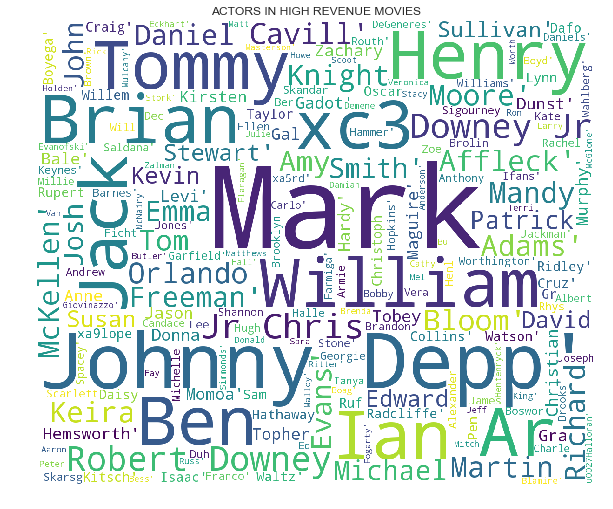

In [43]:
from wordcloud import WordCloud, STOPWORDS
plt.subplots(figsize=(10,10))
text = (str(m['Actors']))
wordcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(text)


plt.imshow(wordcloud)
plt.title('ACTORS IN HIGH REVENUE MOVIES')
plt.axis('off')
plt.show()

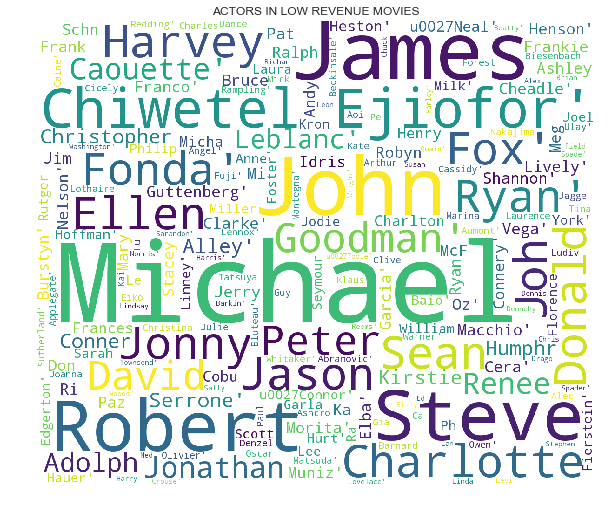

In [44]:
from wordcloud import WordCloud, STOPWORDS
plt.subplots(figsize=(10,10))
text = (str(n['Actors']))
wordcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(text)


plt.imshow(wordcloud)
plt.title('ACTORS IN LOW REVENUE MOVIES')
plt.axis('off')
plt.show()

In [45]:
numeric_features=movies._get_numeric_data().columns.values.tolist()
numeric_features

['Year',
 'Duration_Minutes',
 'Average_Rating',
 'Budget',
 'Opening Weekend',
 'Gross US',
 'Gross WW']

# Correlation heatmap

In [63]:
col = list(movies.describe().columns)
features=col
features
sns.heatmap(movies[features].corr())

In [47]:
movies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
0,Pulp Fiction,1994.0,"['Crime', 'Drama']",R,154.0,"['John Travolta', 'Uma Thurman', 'Samuel L. Ja...",['Quentin Tarantino'],8.9,8000000.0,9311882.0,107928762.0,213928762.0,"['English', 'Spanish', 'French']","['Miramax', 'ABandApart', 'JerseyFilms']"
1,The Amazing Spider-Man 2,2014.0,"['Action', 'Adventure', 'Sci-Fi']",PG-13,142.0,"['Andrew Garfield', 'Emma Stone', 'Jamie Foxx'...",['Marc Webb'],6.6,200000000.0,91608337.0,202853933.0,708982323.0,['English'],"['MarvelEnterprises', 'AviAradProductions', 'C..."
2,The Shawshank Redemption,1994.0,['Drama'],R,142.0,"['Tim Robbins', 'Morgan Freeman', 'Bob Gunton'...",['Frank Darabont'],9.3,25000000.0,727326.0,28341469.0,58500000.0,['English'],['CastleRockEntertainment']
3,Star Wars: Episode IV - A New Hope,1977.0,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",PG,121.0,"['Mark Hamill', 'Harrison Ford', 'Carrie Fishe...",['George Lucas'],8.6,11000000.0,1554475.0,322740140.0,775398007.0,['English'],"['Lucasfilm', 'TwentiethCenturyFox']"
4,Back to the Future,1985.0,"['Adventure', 'Comedy', 'Sci-Fi']",PG,116.0,"['Michael J. Fox', 'Christopher Lloyd', 'Lea T...",['Robert Zemeckis'],8.5,19000000.0,11332134.0,210609762.0,381109762.0,['English'],"['UniversalPictures', 'AmblinEntertainment', '..."


Dummy Encoding for Genres:

In [48]:
movies["Genres"] = movies["Genres"].str.replace('[','')
movies["Genres"] = movies["Genres"].str.replace(']','')
movies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
0,Pulp Fiction,1994.0,"'Crime', 'Drama'",R,154.0,"['John Travolta', 'Uma Thurman', 'Samuel L. Ja...",['Quentin Tarantino'],8.9,8000000.0,9311882.0,107928762.0,213928762.0,"['English', 'Spanish', 'French']","['Miramax', 'ABandApart', 'JerseyFilms']"
1,The Amazing Spider-Man 2,2014.0,"'Action', 'Adventure', 'Sci-Fi'",PG-13,142.0,"['Andrew Garfield', 'Emma Stone', 'Jamie Foxx'...",['Marc Webb'],6.6,200000000.0,91608337.0,202853933.0,708982323.0,['English'],"['MarvelEnterprises', 'AviAradProductions', 'C..."
2,The Shawshank Redemption,1994.0,'Drama',R,142.0,"['Tim Robbins', 'Morgan Freeman', 'Bob Gunton'...",['Frank Darabont'],9.3,25000000.0,727326.0,28341469.0,58500000.0,['English'],['CastleRockEntertainment']
3,Star Wars: Episode IV - A New Hope,1977.0,"'Action', 'Adventure', 'Fantasy', 'Sci-Fi'",PG,121.0,"['Mark Hamill', 'Harrison Ford', 'Carrie Fishe...",['George Lucas'],8.6,11000000.0,1554475.0,322740140.0,775398007.0,['English'],"['Lucasfilm', 'TwentiethCenturyFox']"
4,Back to the Future,1985.0,"'Adventure', 'Comedy', 'Sci-Fi'",PG,116.0,"['Michael J. Fox', 'Christopher Lloyd', 'Lea T...",['Robert Zemeckis'],8.5,19000000.0,11332134.0,210609762.0,381109762.0,['English'],"['UniversalPictures', 'AmblinEntertainment', '..."


In [49]:
#movies= movies.set_index('Name').Genres.str.split(',', expand=True).stack() # this is converting the dataframe to series.. do we need this??

In [50]:
movies.head(5)

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
0,Pulp Fiction,1994.0,"'Crime', 'Drama'",R,154.0,"['John Travolta', 'Uma Thurman', 'Samuel L. Ja...",['Quentin Tarantino'],8.9,8000000.0,9311882.0,107928762.0,213928762.0,"['English', 'Spanish', 'French']","['Miramax', 'ABandApart', 'JerseyFilms']"
1,The Amazing Spider-Man 2,2014.0,"'Action', 'Adventure', 'Sci-Fi'",PG-13,142.0,"['Andrew Garfield', 'Emma Stone', 'Jamie Foxx'...",['Marc Webb'],6.6,200000000.0,91608337.0,202853933.0,708982323.0,['English'],"['MarvelEnterprises', 'AviAradProductions', 'C..."
2,The Shawshank Redemption,1994.0,'Drama',R,142.0,"['Tim Robbins', 'Morgan Freeman', 'Bob Gunton'...",['Frank Darabont'],9.3,25000000.0,727326.0,28341469.0,58500000.0,['English'],['CastleRockEntertainment']
3,Star Wars: Episode IV - A New Hope,1977.0,"'Action', 'Adventure', 'Fantasy', 'Sci-Fi'",PG,121.0,"['Mark Hamill', 'Harrison Ford', 'Carrie Fishe...",['George Lucas'],8.6,11000000.0,1554475.0,322740140.0,775398007.0,['English'],"['Lucasfilm', 'TwentiethCenturyFox']"
4,Back to the Future,1985.0,"'Adventure', 'Comedy', 'Sci-Fi'",PG,116.0,"['Michael J. Fox', 'Christopher Lloyd', 'Lea T...",['Robert Zemeckis'],8.5,19000000.0,11332134.0,210609762.0,381109762.0,['English'],"['UniversalPictures', 'AmblinEntertainment', '..."


In [51]:
pd.get_dummies(movies).groupby(level=0).sum()

,Year,Duration_Minutes,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Name_$5 a Day,Name_(500) Days of Summer,Name_*batteries not included,...,"Production Company_['bajanVistaProductions', 'Endocom', 'MadcatProductions']",Production Company_['doubleAFilms'],Production Company_['erbp'],Production Company_['fiftyfilms'],Production Company_['i5Films'],Production Company_['micro_scope'],"Production Company_['nWavePictures', 'IlluminataPictures', 'LeTaxShelterduGouvernementF\\xc3\\xa9d\\xc3\\xa9raldeBelgique']","Production Company_['nWavePictures', 'IlluminataPictures', 'uFilm']",Production Company_['part2pictures'],Production Company_[]
0,1994.0,154.0,8.9,8000000.0,9311882.0,107928762.0,2.139288e+08,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2014.0,142.0,6.6,200000000.0,91608337.0,202853933.0,7.089823e+08,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1994.0,142.0,9.3,25000000.0,727326.0,28341469.0,5.850000e+07,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1977.0,121.0,8.6,11000000.0,1554475.0,322740140.0,7.753980e+08,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1985.0,116.0,8.5,19000000.0,11332134.0,210609762.0,3.811098e+08,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1985.0,97.0,7.9,1000000.0,5107599.0,45875171.0,5.152517e+07,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1985.0,114.0,7.8,19000000.0,9105913.0,61503218.0,-1.000000e+00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1991.0,118.0,8.6,19000000.0,13766814.0,130742922.0,2.727429e+08,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1993.0,127.0,8.1,63000000.0,50159460.0,402453882.0,1.029154e+09,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1994.0,88.0,8.5,45000000.0,1825849.0,312900000.0,9.874838e+08,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
movies.to_excel('output.xlsx')

In [53]:
movies = movies[~((movies['Year'] == 0) & (movies['Rating'] == 'Unrated') & (movies['Duration_Minutes'] == -1) & (movies['Actors'] == " ")& (movies['Average_Rating'] == -1) & (movies['Director'] == " ")& (movies['Budget'] == -1))]
#remove 

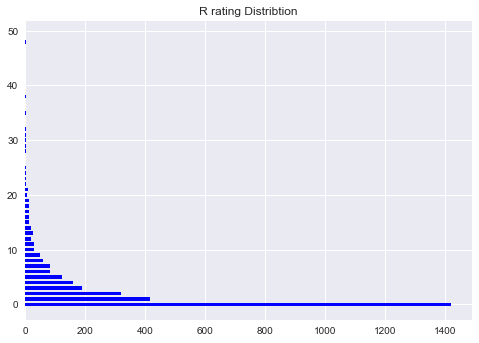

Mean Value:  22307293.404173356


In [111]:
R = movies[movies["Rating"] == 'R']
R = R[R["Gross US"] > 0]
R = R.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
grouping = R.groupby(pd.cut(R["Gross US"], groups)).count()
y_pos = np.arange(len(grouping))
plt.barh(y_pos , grouping["Gross US"], 1/1.5, color="blue")
plt.title("R rating Distribtion")
plt.show()
print("Mean Value: ", R["Gross US"].mean())

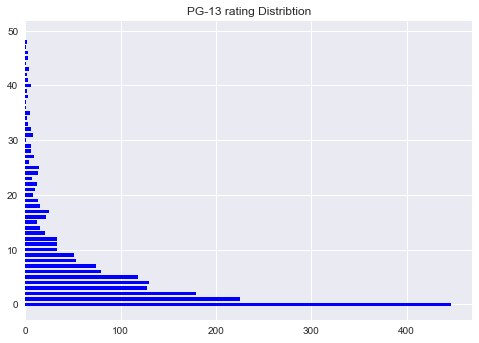

Mean Value:  53138836.04487179


In [112]:
R = movies[movies["Rating"] == 'PG-13']
R = R[R["Gross US"] > 0]
R = R.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
grouping = R.groupby(pd.cut(R["Gross US"], groups)).count()
y_pos = np.arange(len(grouping))
plt.barh(y_pos , grouping["Gross US"], 1/1.5, color="blue")
plt.title("PG-13 rating Distribtion")
plt.show()
print("Mean Value: ", R["Gross US"].mean())

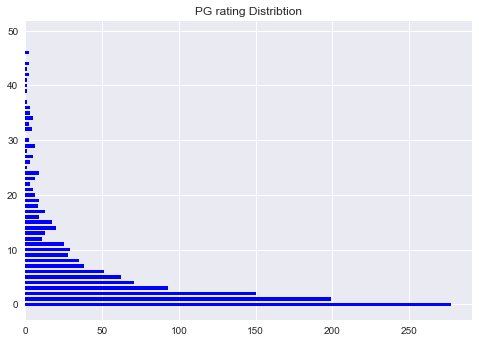

Mean Value:  45046947.61904762


In [113]:
R = movies[movies["Rating"] == 'PG']
R = R[R["Gross US"] > 0]
R = R.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
grouping = R.groupby(pd.cut(R["Gross US"], groups)).count()
y_pos = np.arange(len(grouping))
plt.barh(y_pos , grouping["Gross US"], 1/1.5, color="blue")
plt.title("PG rating Distribtion")
plt.show()
print("Mean Value: ", R["Gross US"].mean())

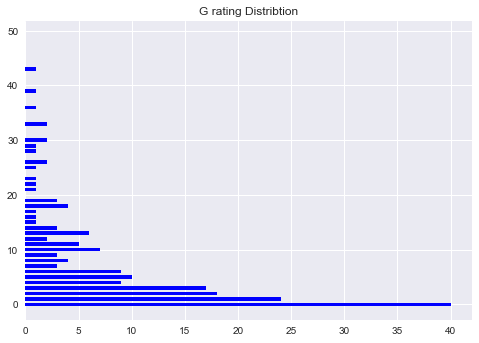

Mean Value:  54896717.31550802


In [114]:
R = movies[movies["Rating"] == 'G']
R = R[R["Gross US"] > 0]
R = R.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
grouping = R.groupby(pd.cut(R["Gross US"], groups)).count()
y_pos = np.arange(len(grouping))
plt.barh(y_pos , grouping["Gross US"], 1/1.5, color="blue")
plt.title("G rating Distribtion")
plt.show()
print("Mean Value: ", R["Gross US"].mean())